In [74]:
import pandas as pd
import numpy as np
import nltk
import urllib
import requests
import string
import os
import matplotlib.pyplot as plt
import csv
import re
import unicodedata
import seaborn as sns

from sklearn.naive_bayes import MultinomialNB

from sklearn.feature_extraction.text import CountVectorizer
# TODO: need onehot?
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

In [75]:
news_df = pd.read_csv(os.path.join('news-data', 'uci-news-aggregator.csv'), header=0, index_col=0, dtype=str)
print('Read .csv file from local copy of dataset.')

Read .csv file from local copy of dataset.


In [76]:
news_df.head()

,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
ID,,,,,,,
1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


In [77]:
#news_df.isnull().sum() #THERE ARE 2 NULL PUBLISHERS

category_dict = {
    'b':'business',
    'e':'entertainment',
    'm':'health',
    't':'science/technology'
}
news_df['CATEGORY'] = news_df['CATEGORY'].map(category_dict)

In [78]:
news_df.head()

,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
ID,,,,,,,
1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,business,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,business,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,business,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,business,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,business,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


In [79]:
def remove_stopwords(s1):
    s1 = ' '.join([unicodedata.normalize("NFKD", word)
                   for word in s1.split()
                   if word not in nltk.corpus.stopwords.words('english')])
    return s1

In [80]:
def remove_punctuation(s1):
    """
    Returns s1 without punctuation that is not word-internal (e.g., hyphens, apostrophes)
    removed.
    """
    # TODO: optimise with pandas' str replace
    
    # remove punctuation that is not word-internal (e.g., hyphens, apostrophes)
    s1 = re.sub('\b\W+',' ',s1)
    s1 = re.sub('\W+\b',' ',s1)
    #s1 = re.sub('(\b\W+)|(\W+\b)',' ',s1)
    return s1

In [81]:
news_df['TITLE'] = news_df['TITLE'].str.lower()
news_df['TITLE'] = news_df['TITLE'].apply(remove_punctuation)
#title = unicodedata.normalize("NFKD", title)

In [82]:
vectorizer = CountVectorizer()
vectorizer.fit(news_df['TITLE'])
features = vectorizer.transform(news_df['TITLE'])

encoder = LabelEncoder()
encoder.fit(news_df['CATEGORY'])
labels = encoder.transform(news_df['CATEGORY'])

In [83]:
# split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((337935, 54637), (84484, 54637), (337935,), (84484,))

In [84]:
nb = MultinomialNB()
nb.fit(x_train, y_train)

nb.score(x_test, y_test)

0.9269684200558685

In [85]:
def predict_categories(model, title):

    title = title.lower()
    title = remove_punctuation(title)
    
    text = vectorizer.transform([title])
    category = model.predict(text)
    
    return encoder.inverse_transform(category)[0]
    

In [86]:
predict_categories(nb, 'The Sea’s Weirdest Creatures, Now in ‘Staggering’ Detail')

'science/technology'

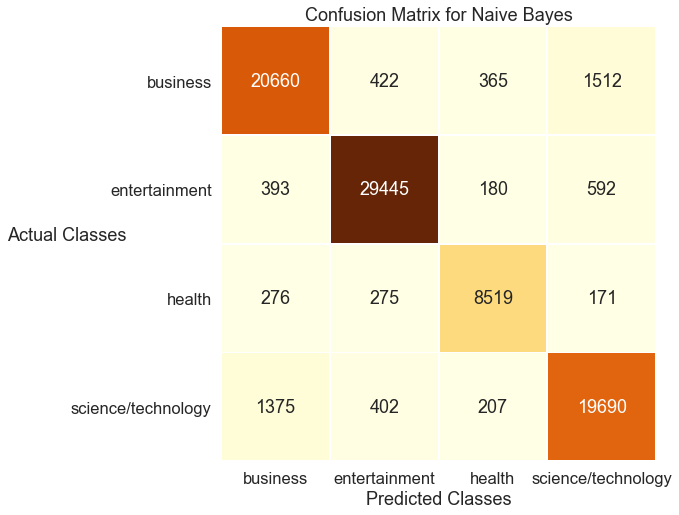

In [92]:
from sklearn.metrics import confusion_matrix

y_pred = nb.predict(x_test)
matrix = confusion_matrix(y_test, y_pred)

def confusion_mat(model_name, confusion_matrix, cmap='YlOrBr'):
    #hardcoded index and columns
    cof=pd.DataFrame(confusion_matrix)
    sns.set(font_scale=1.5)
    plt.figure(figsize=(8,8))

    sns.heatmap(cof, cmap=cmap,linewidths=1, annot=True,square=True, fmt='d', cbar=False,
                xticklabels=category_dict.values(),
                yticklabels=category_dict.values())
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Classes', rotation=0)
    plt.ylabel('Actual Classes', rotation=0)
    
confusion_mat('Naive Bayes', matrix)